In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (64598, 56, 56)   out (64598, 24, 24)
in (8075, 56, 56)   out (8075, 24, 24)


In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(64598, 56, 56, 1) (64598, 24, 24, 1)
(8075, 56, 56, 1) (8075, 24, 24, 1)


In [7]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

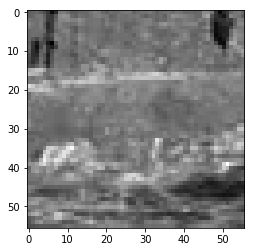

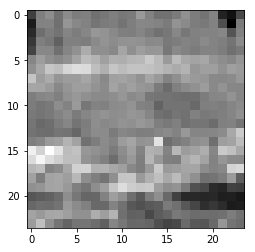

In [8]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [16]:
# my_adadelta = keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)

In [9]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [11]:
# from keras.callbacks import Callback

# # taken from https://github.com/keras-team/keras/issues/7874#issuecomment-329347949

# class LRPrintCallback(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         lr = self.model.optimizer.lr
#         decay = self.model.optimizer.decay
#         iterations = self.model.optimizer.iterations
#         lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
#         print(K.eval(lr_with_decay))
#         print(K.eval(lr))
#         print(K.eval(decay))
        
# lr_printer = LRPrintCallback()

In [10]:
model_version_previous = '0.0.2.1.0_decoder_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24'
brief_ae_previous = load_model(base_dir + '/brief_ae_' + model_version_previous + '.h5')

In [11]:
brief_ae_previous.get_layer(index=7).get_weights()[0].shape

(512, 1152)

In [12]:
for i in range(7, len(brief_ae.layers)):
    print(brief_ae_previous.get_layer(index=i))
    brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [ ]:
model_version = '0.0.2.1.1_whole_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24_train30more'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
64598/64598 [==============================] - 2604s 40ms/step - loss: 0.5347 - val_loss: 0.5695
Epoch 2/50
64598/64598 [==============================] - 2602s 40ms/step - loss: 0.5347 - val_loss: 0.5548
Epoch 3/50
64598/64598 [==============================] - 2605s 40ms/step - loss: 0.5347 - val_loss: 0.5085
Epoch 4/50
64598/64598 [==============================] - 2605s 40ms/step - loss: 0.5347 - val_loss: 0.5243
Epoch 5/50
64598/64598 [==============================] - 2603s 40ms/step - loss: 0.5347 - val_loss: 0.5306
Epoch 6/50
64598/64598 [==============================] - 2605s 40ms/step - loss: 0.5347 - val_loss: 0.5309
Epoch 7/50
64598/64598 [==============================] - 2604s 40ms/step - loss: 0.5346 - val_loss: 0.5483
Epoch 8/50
64598/64598 [==============================] - 2605s 40ms/step - loss: 0.5346 - val_loss: 0.5346
Epoch 9/50
64598/64598 [==============================] - 2604s 40ms/step - loss: 0.5346 - val_loss: 0.5245
Epoch 10/50
64598/64598 [===

In [19]:
history_callback.history

{'val_loss': [0.5695395469665527,
  0.5547953844070435,
  0.5085437297821045,
  0.5243029594421387,
  0.5305707454681396,
  0.5308789014816284,
  0.5482789278030396,
  0.5346052646636963,
  0.5245465040206909,
  0.5339305996894836,
  0.5109469890594482,
  0.538398027420044,
  0.5287423729896545,
  0.5238413214683533,
  0.5388285517692566,
  0.5091723203659058,
  0.508829653263092,
  0.5337586998939514,
  0.5233927965164185,
  0.5068030953407288,
  0.522394597530365,
  0.5203709006309509,
  0.5739521980285645,
  0.5635069012641907,
  0.5838603973388672,
  0.5250361561775208,
  0.5587520599365234,
  0.5583359003067017,
  0.4927084147930145,
  0.48773181438446045,
  0.5525521039962769,
  0.5210898518562317,
  0.5249912738800049,
  0.5496646165847778,
  0.5359187722206116,
  0.5721678137779236,
  0.5244086384773254,
  0.5314443111419678,
  0.5322868824005127,
  0.5289802551269531,
  0.521472692489624,
  0.5198169350624084,
  0.5047063827514648,
  0.5098345279693604,
  0.5165470838546753,
 

predictions: 


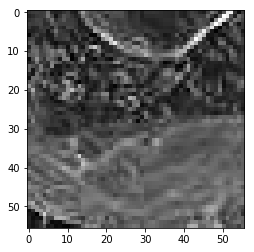

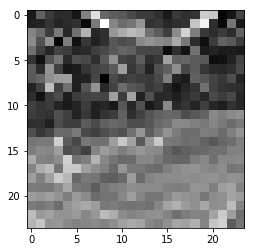

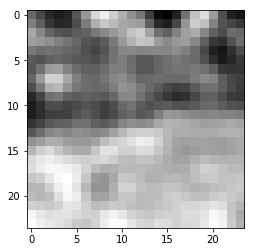

19.779798723757267

 next


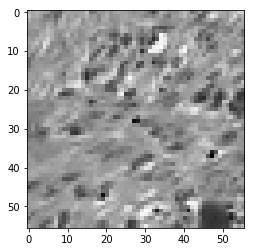

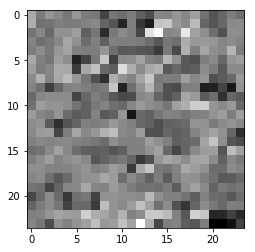

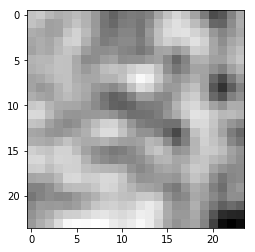

21.009906716644764

 next


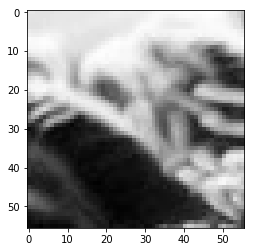

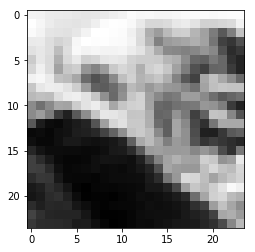

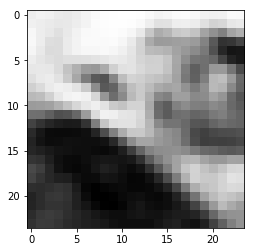

19.32915050536394

 next


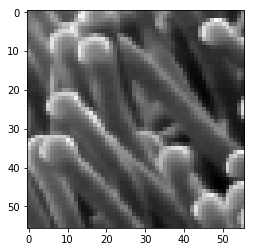

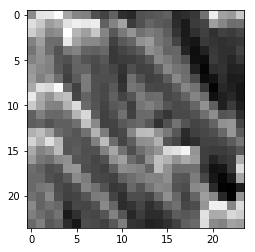

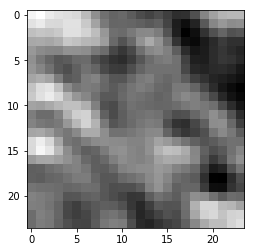

16.030002236366272

 next


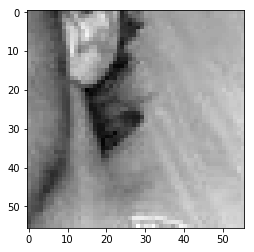

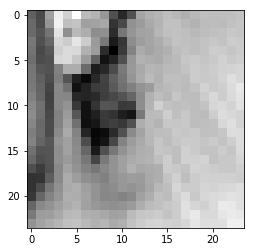

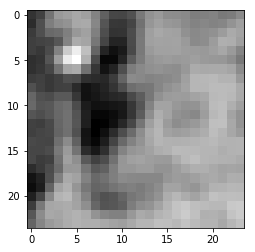

9.386592619121075

 next


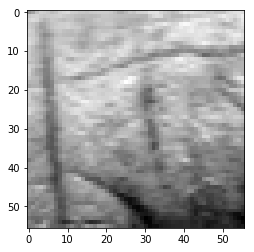

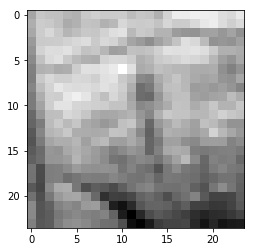

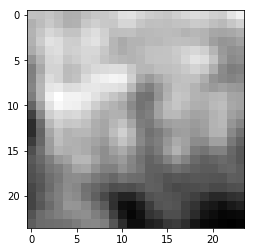

10.649577397853136

 next


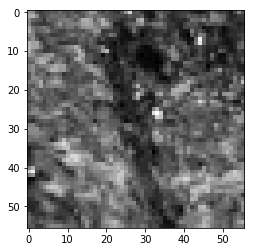

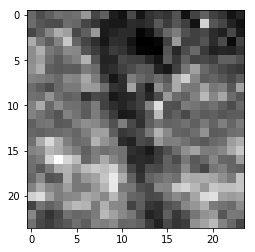

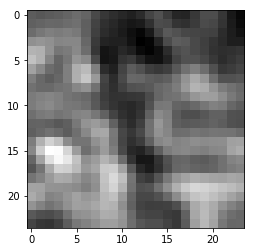

21.227545738220215

 next


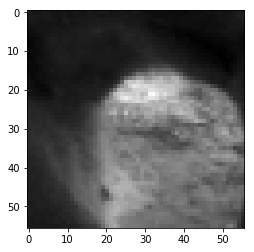

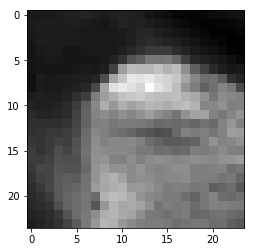

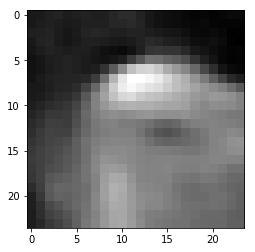

12.310367580503225

 next


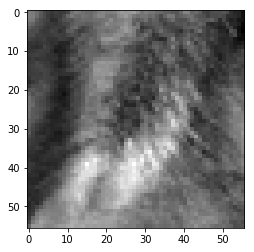

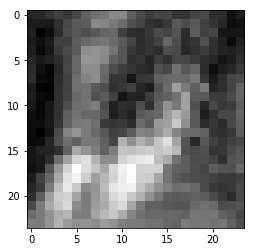

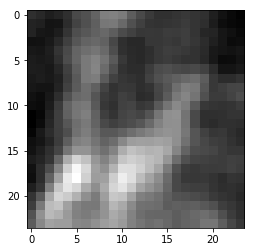

10.096577871590853

 next


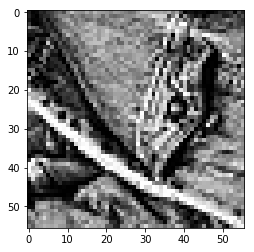

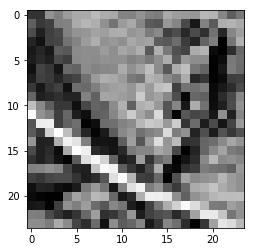

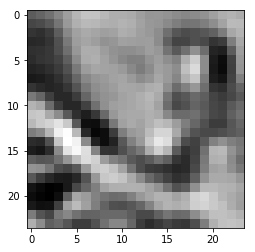

38.57195444405079

 next


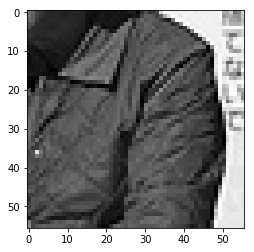

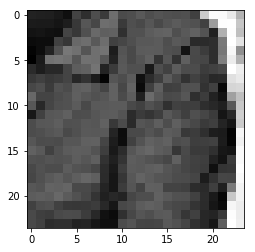

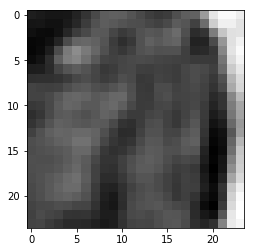

22.814726270735264

 next


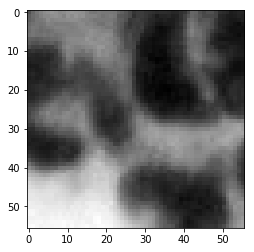

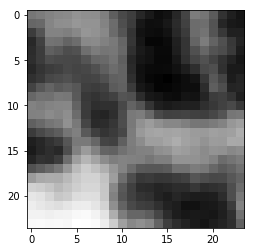

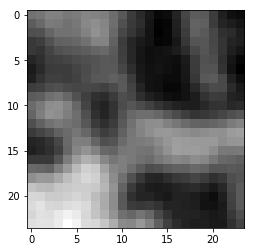

9.527875687927008

 next


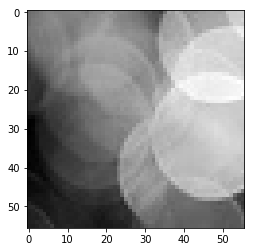

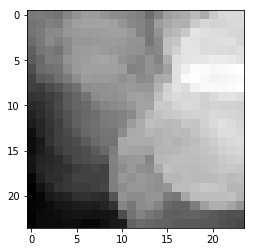

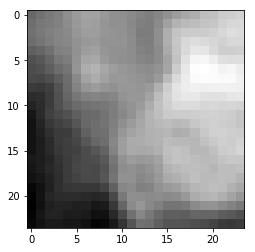

10.039779469370842

 next


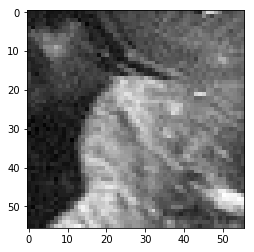

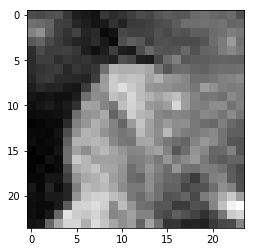

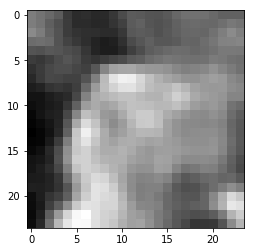

11.690098363906145

 next


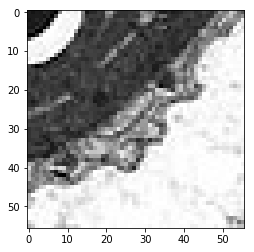

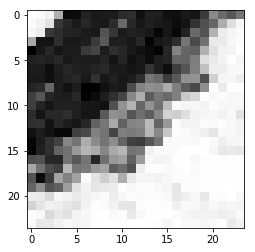

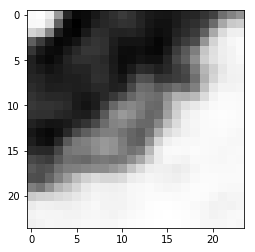

21.268541738390923

 next


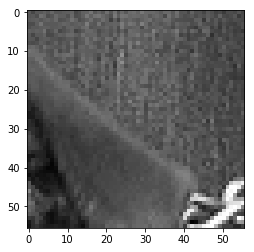

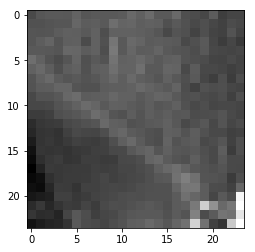

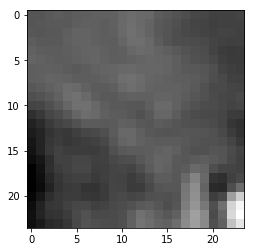

13.148896135389805

 next


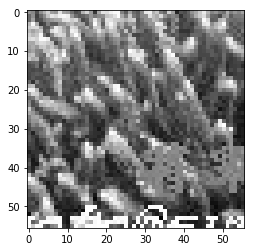

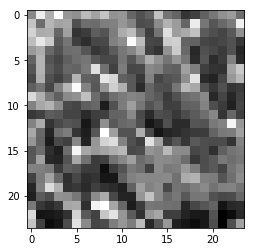

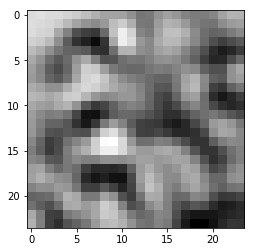

27.959995977580547

 next


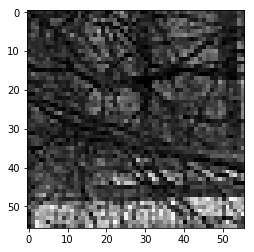

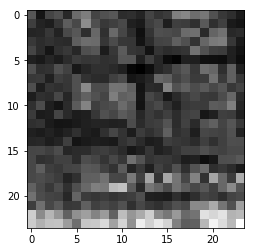

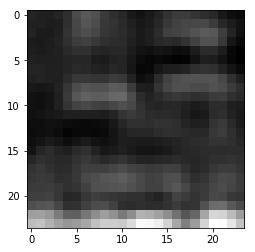

21.387796439230442

 next


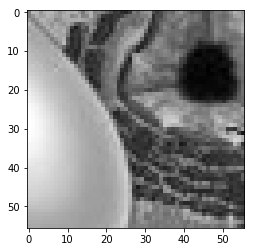

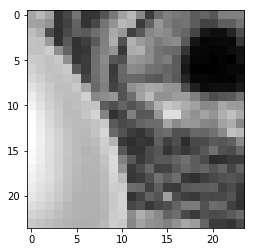

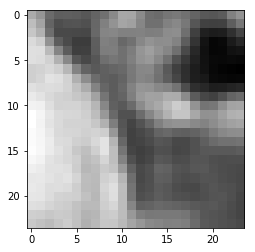

17.601597905158997

 next


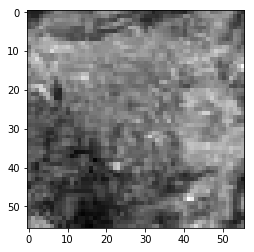

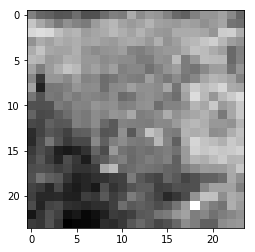

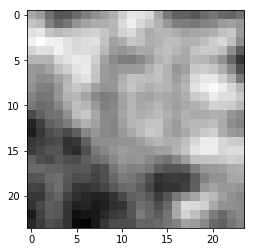

8.330173306167126

 next


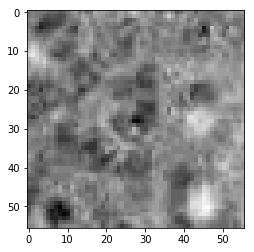

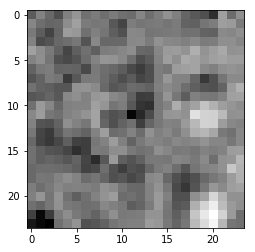

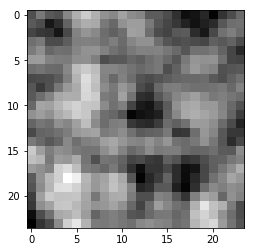

9.584707338362932

 next


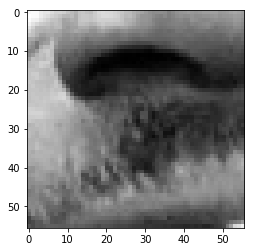

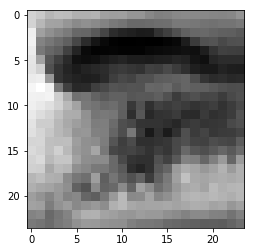

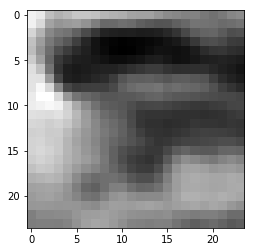

12.155341599136591

 next


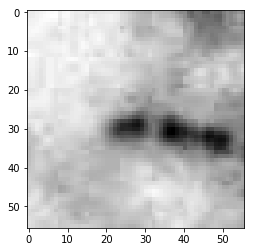

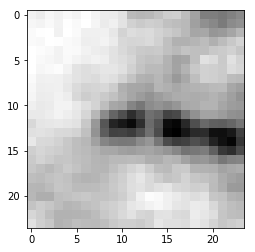

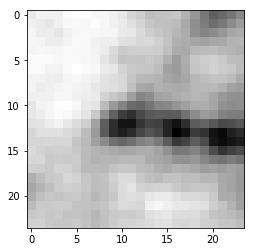

9.153290838003159

 next


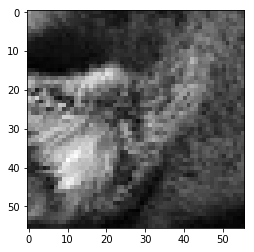

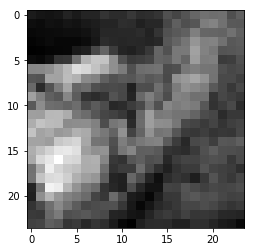

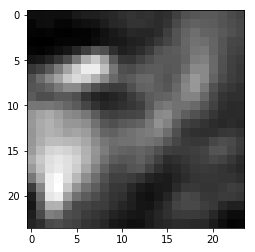

14.65969791635871

 next


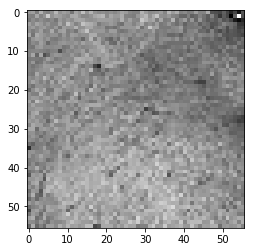

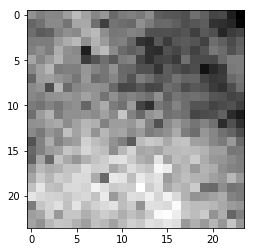

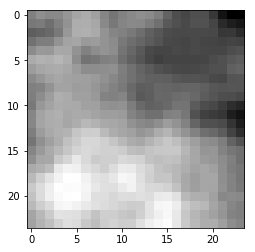

11.229435782879591

 next


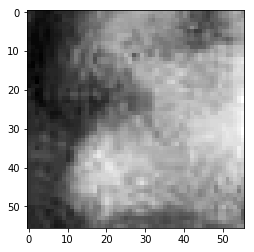

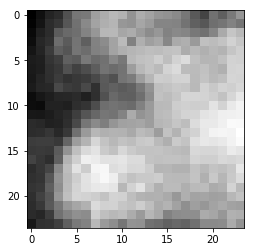

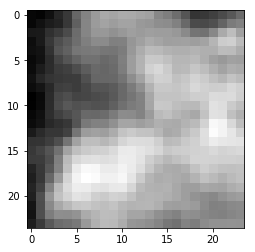

9.174486100673676

 next


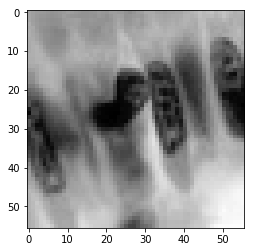

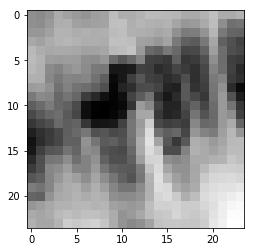

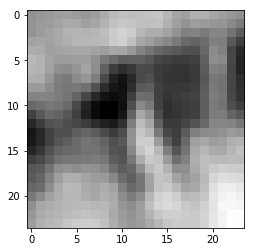

14.050801489502192

 next


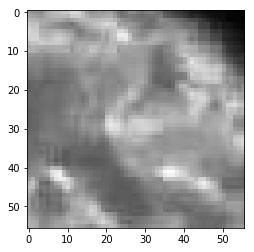

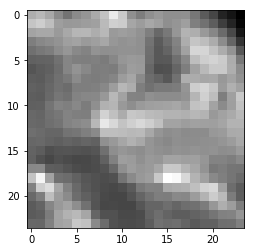

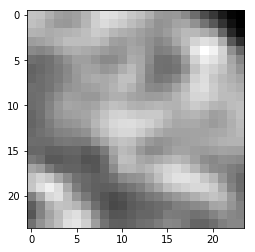

10.336567293852568

 next


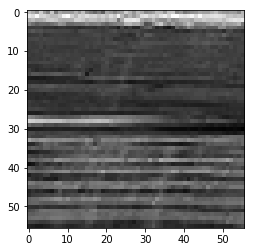

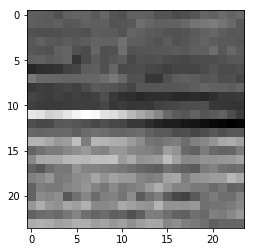

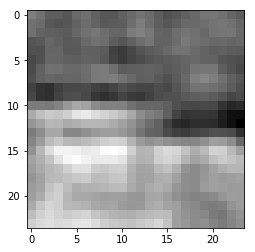

13.68226021528244

 next


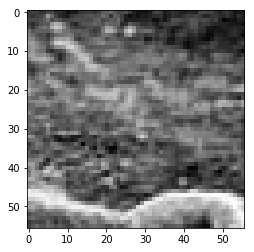

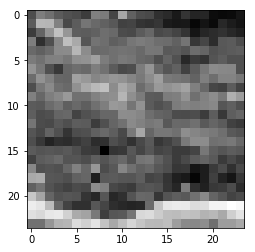

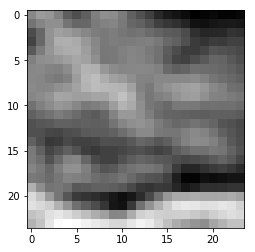

16.15608137100935

 next


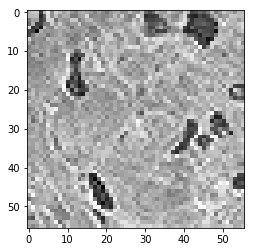

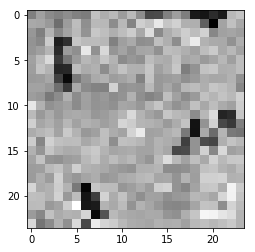

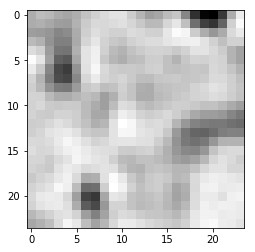

22.051518224179745

 next


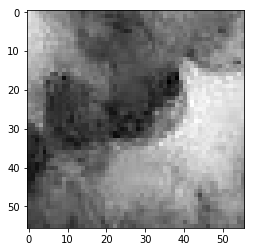

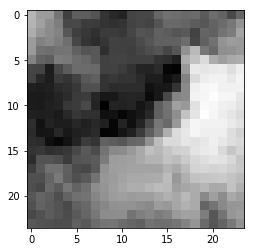

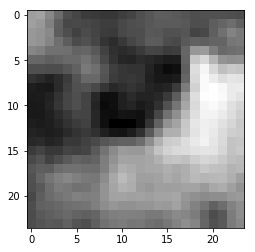

9.4783690944314

 next


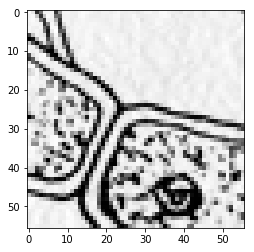

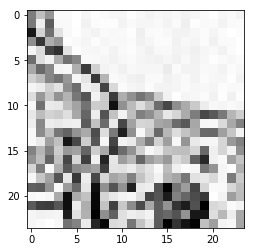

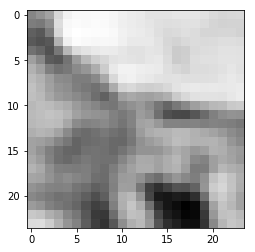

46.11052952706814

 next


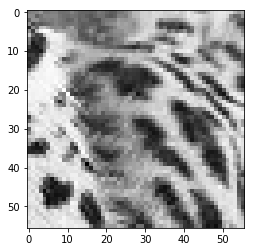

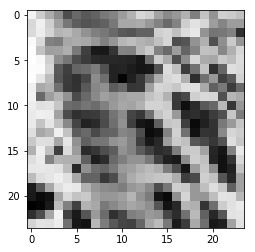

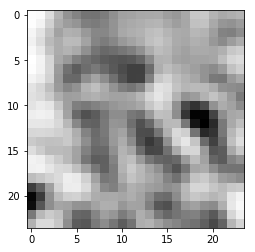

29.902503043413162

 next


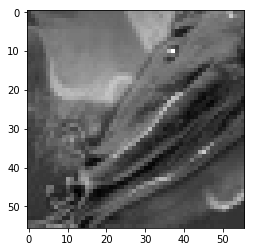

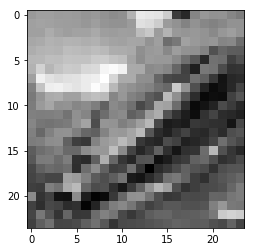

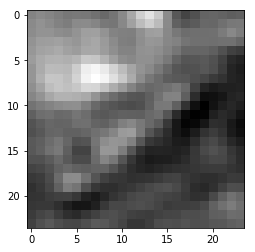

14.719254970550537

 next


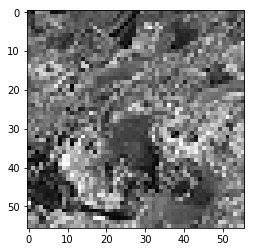

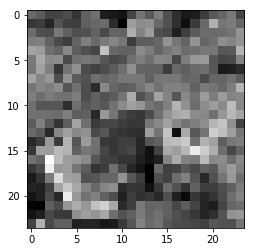

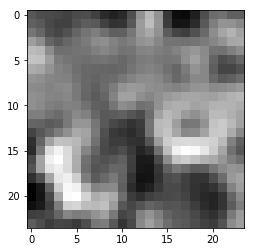

24.341001771390438

 next


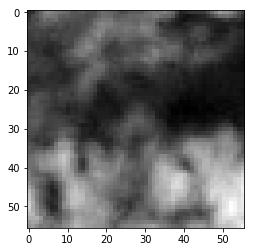

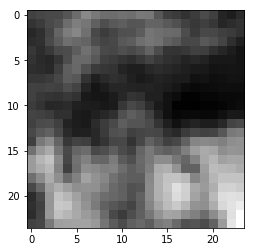

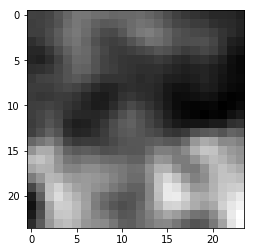

11.622643433511257

 next


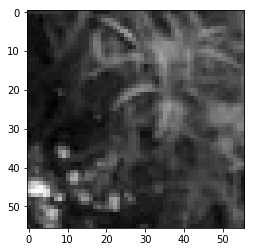

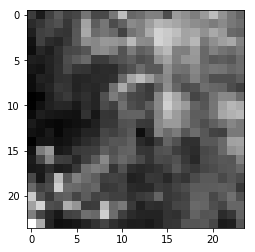

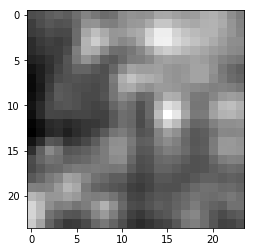

13.75403931364417

 next


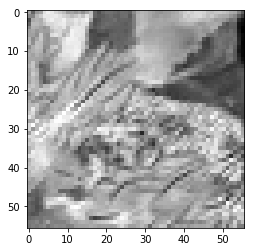

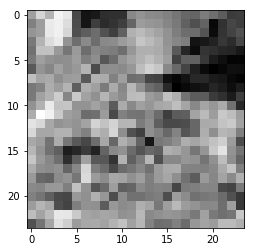

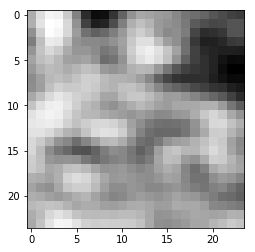

21.199985817074776

 next


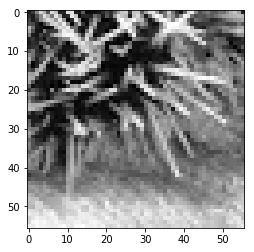

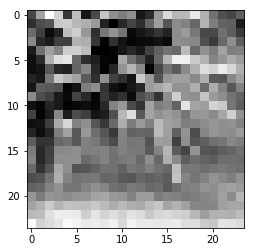

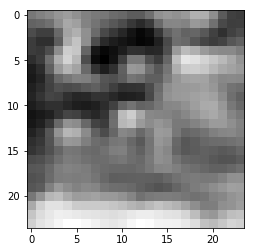

30.391960479319096

 next


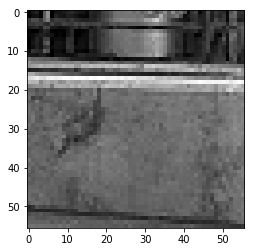

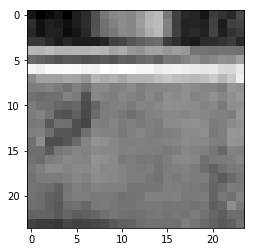

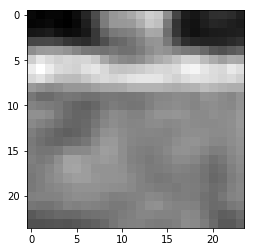

18.126990012824535

 next


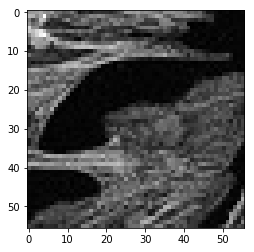

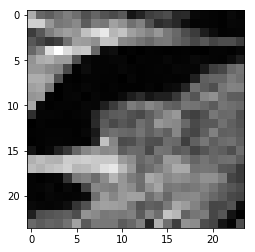

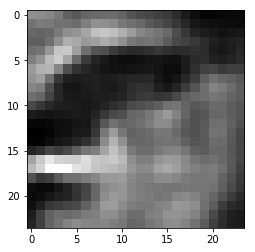

13.633991405367851

 next


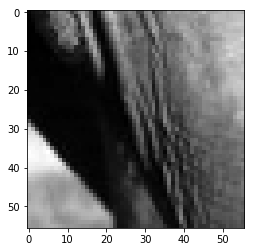

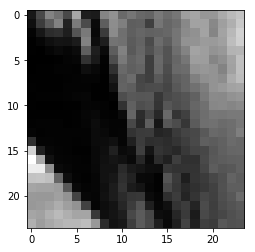

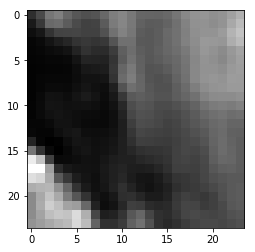

14.089567959308624

 next


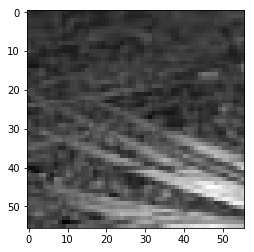

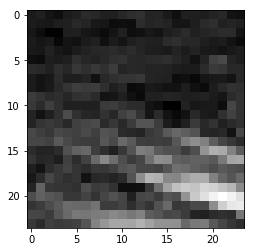

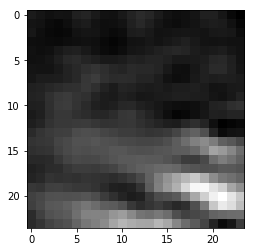

13.753513991832733

 next


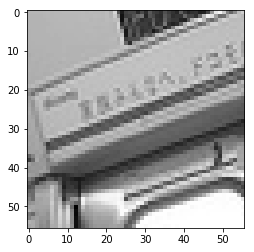

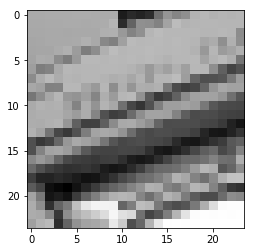

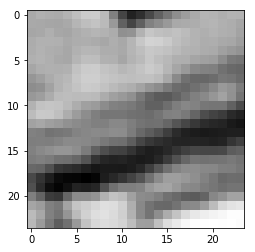

24.463814981281757

 next


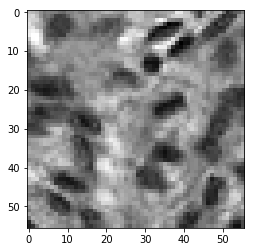

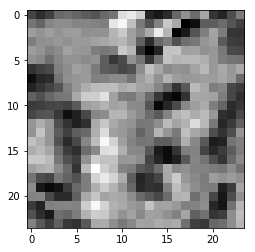

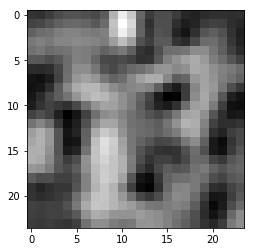

18.307786211371422

 next


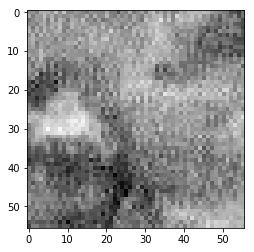

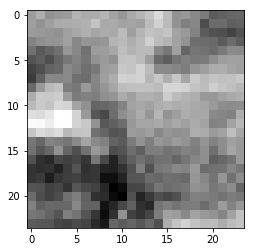

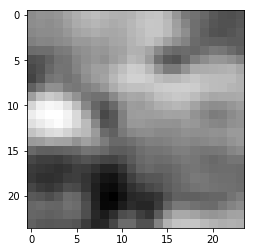

13.705659359693527

 next


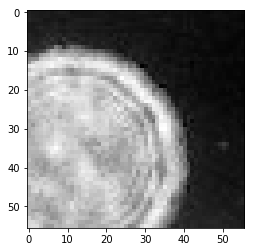

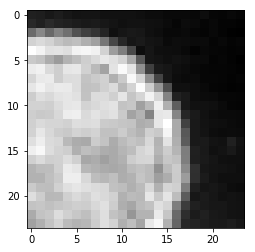

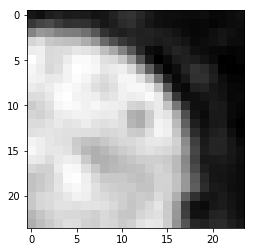

12.12934909388423

 next


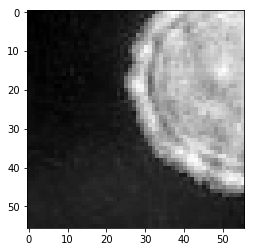

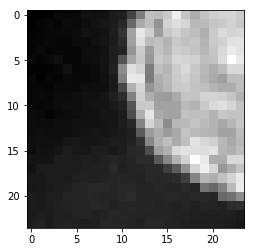

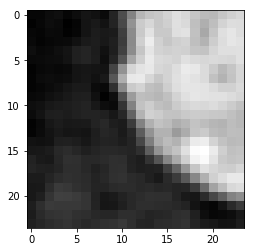

10.388767942786217

 next


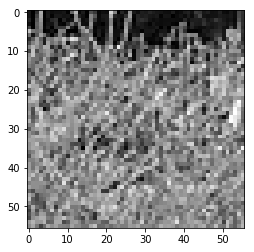

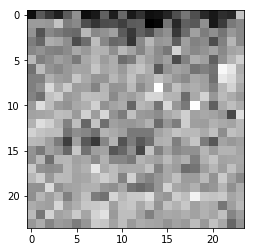

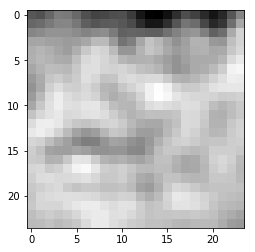

23.99555280804634

 next


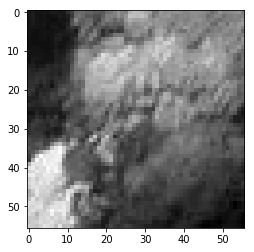

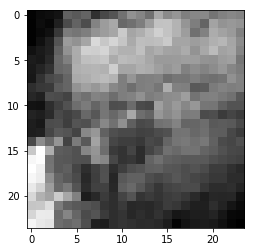

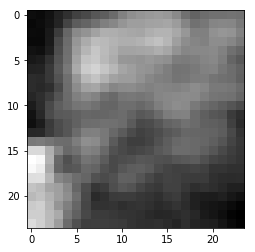

10.627657324075699

 next


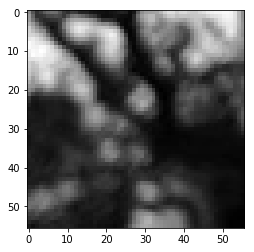

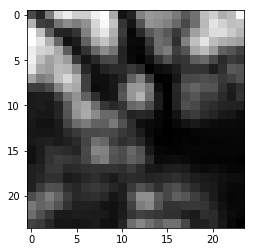

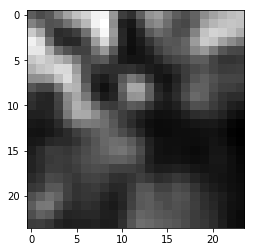

15.948154628276825

 next


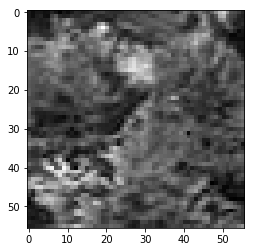

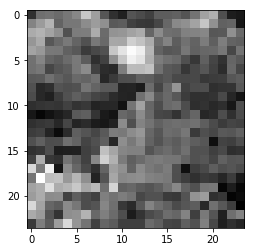

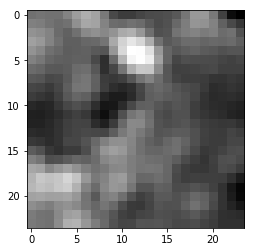

15.266687795519829

 next


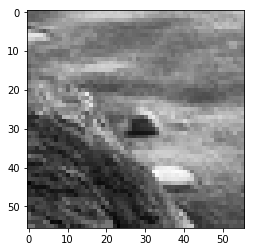

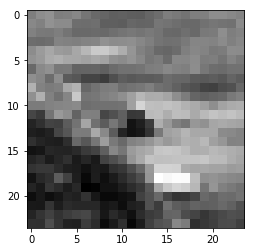

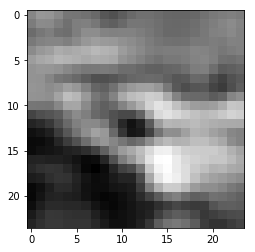

14.267479162663221

 next


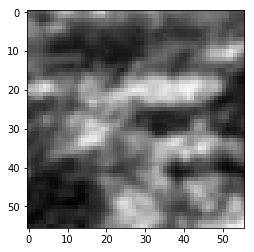

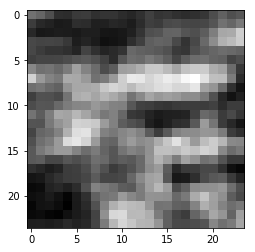

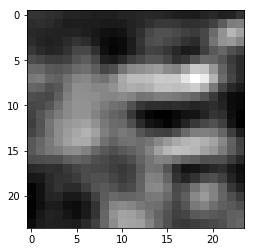

10.670900903642178

 next


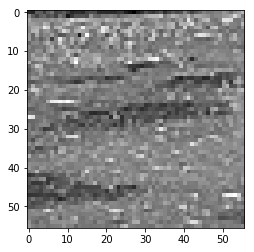

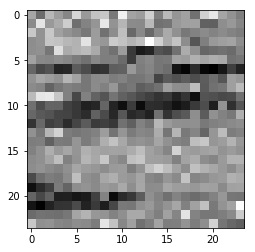

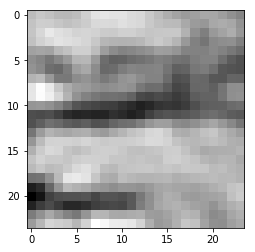

17.091596871614456

 next


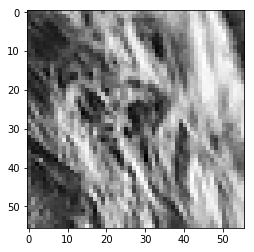

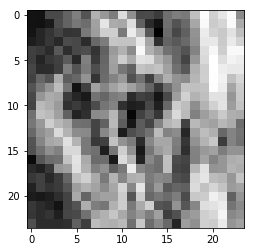

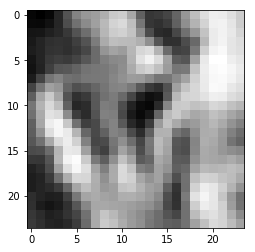

26.293656192719936

 next


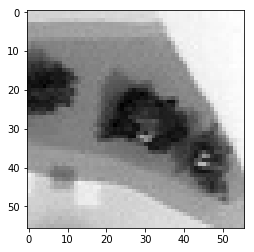

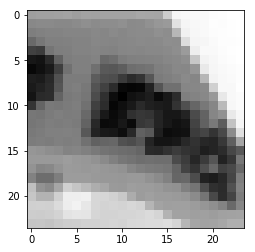

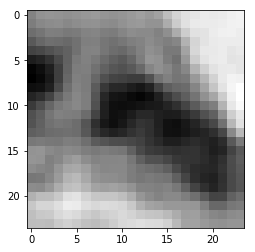

12.941332273185253

 next


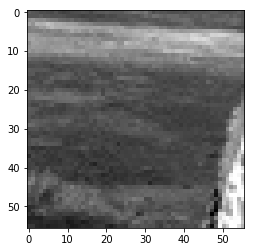

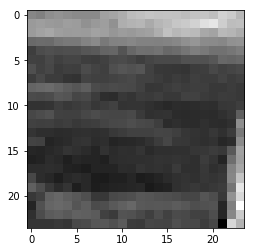

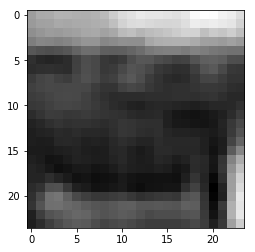

12.319276202470064

 next


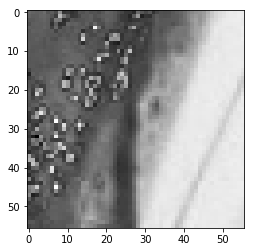

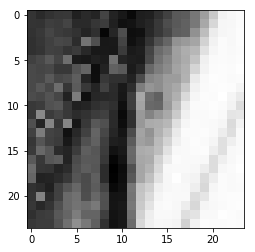

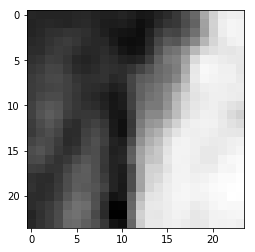

13.836615532636642

 next


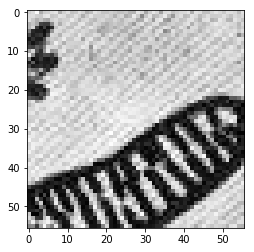

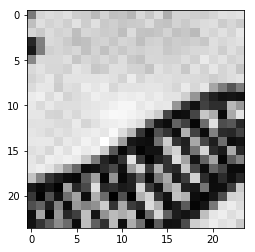

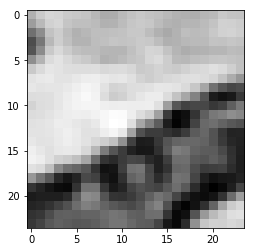

34.713512286543846

 next


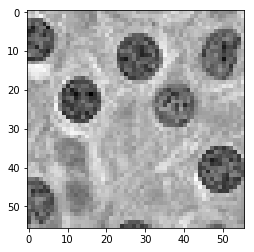

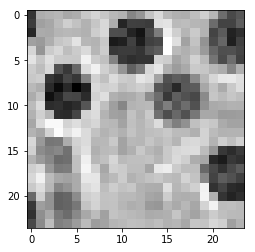

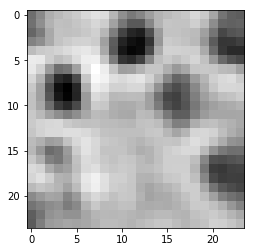

18.907956406474113

 next


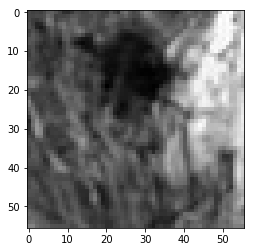

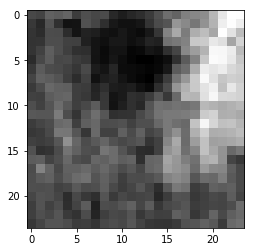

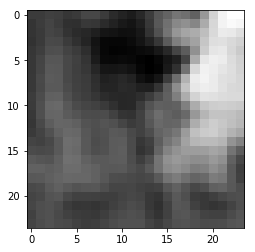

15.284835621714592

 next


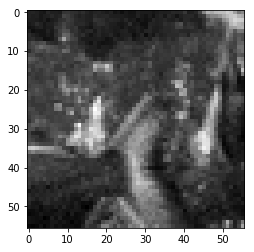

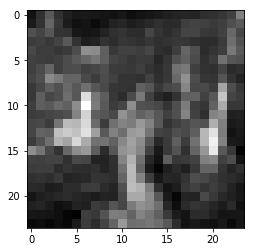

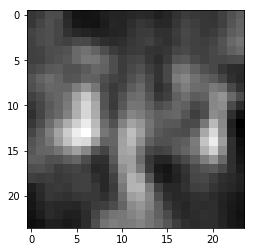

13.653727546334267

 next


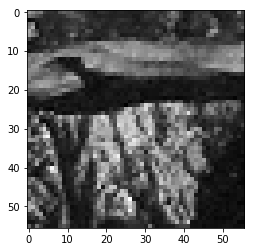

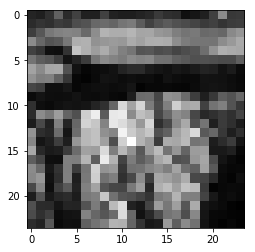

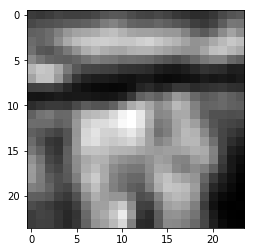

23.763681650161743

 next


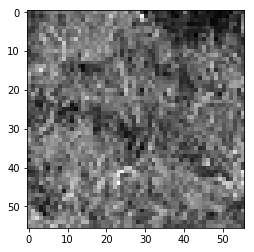

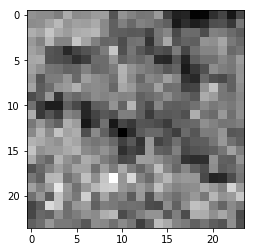

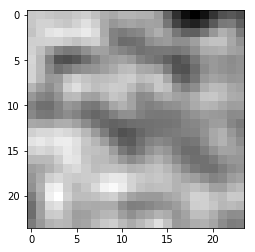

14.890168849378824

 next


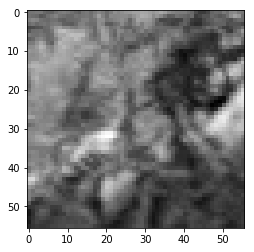

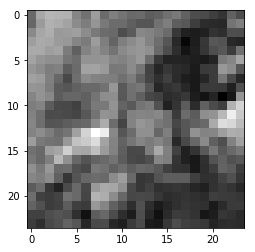

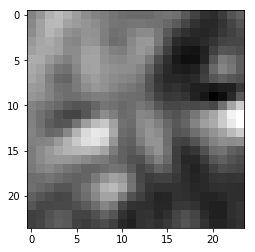

14.714732263237238

 next


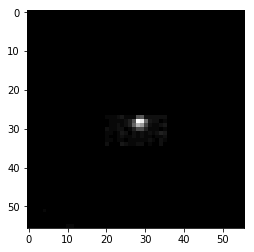

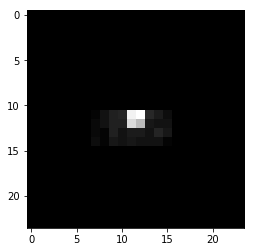

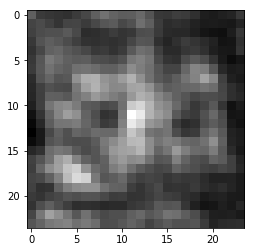

6.301741925999522

 next


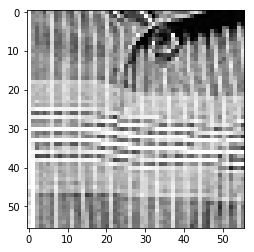

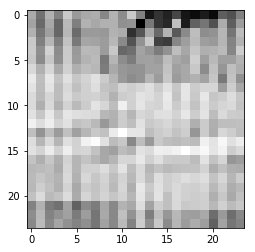

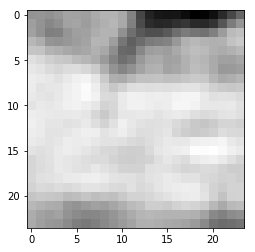

23.89362707734108

 next


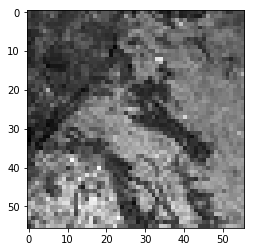

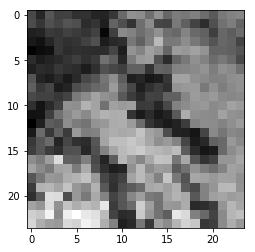

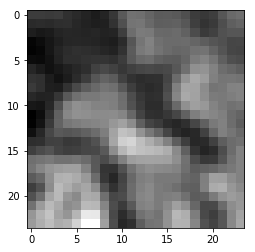

13.79196222871542

 next


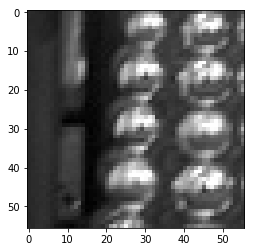

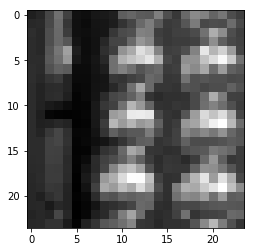

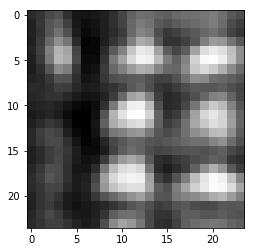

24.402357079088688

 next


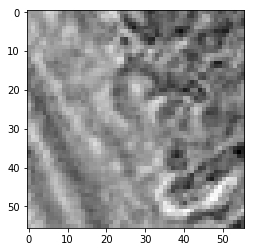

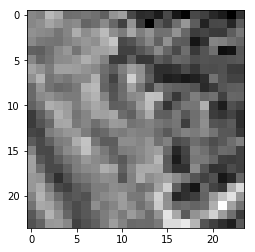

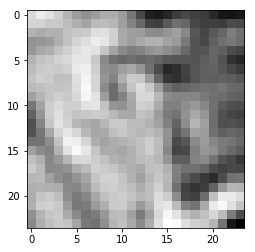

16.057206876575947

 next


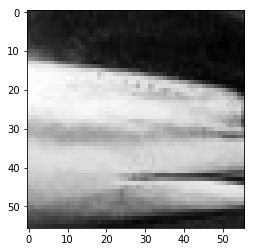

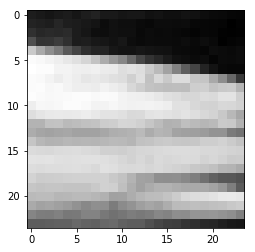

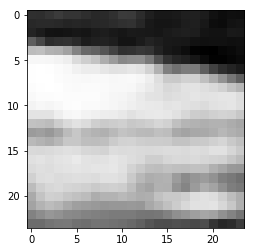

14.065967425704002

 next


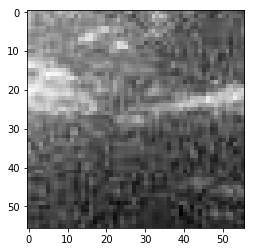

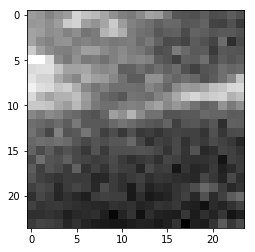

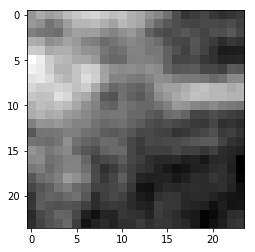

8.683678787201643

 next


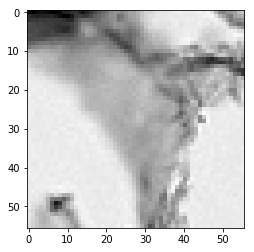

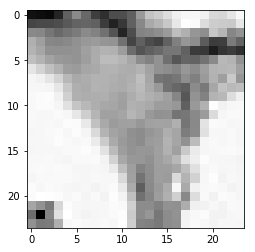

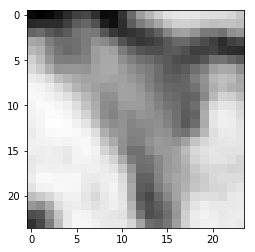

12.906553689390421

 next


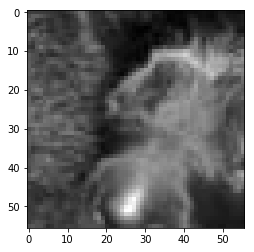

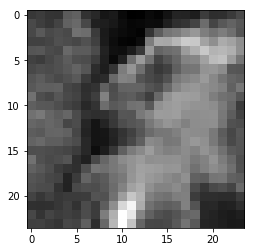

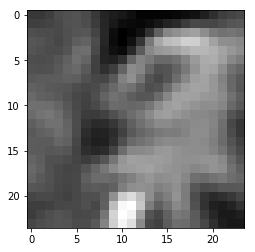

13.68963086977601

 next


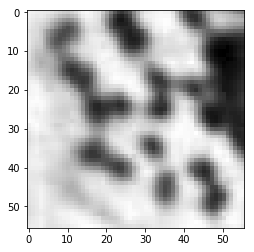

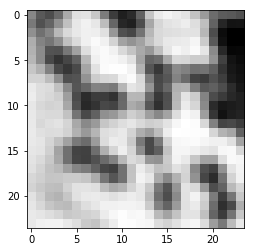

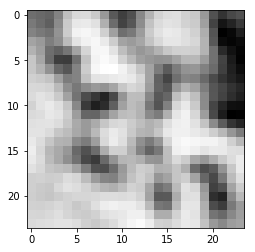

11.979234348982573

 next


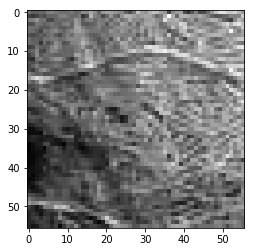

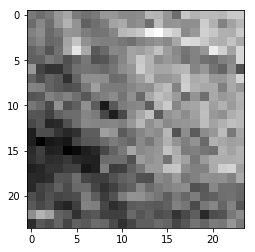

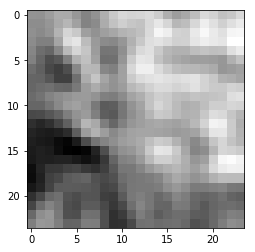

13.126730974763632

 next


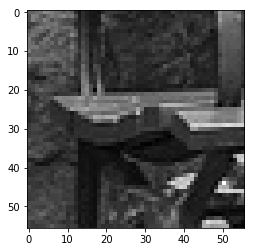

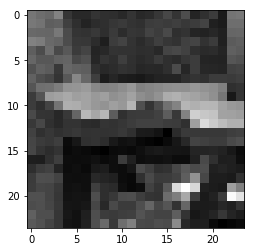

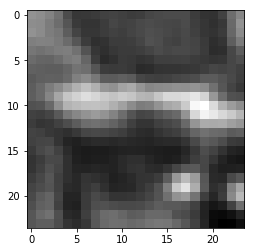

14.881321974098682

 next


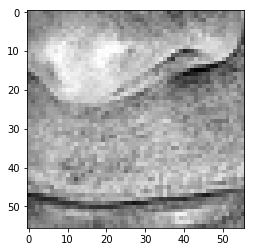

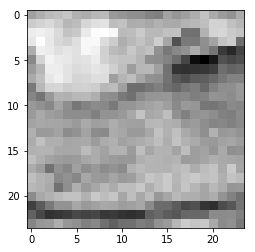

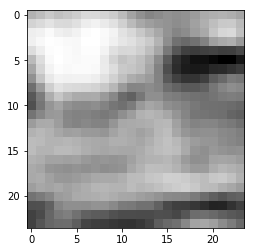

20.01098971813917

 next


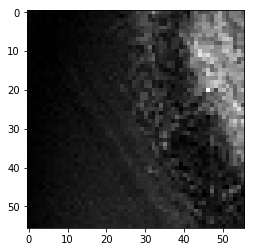

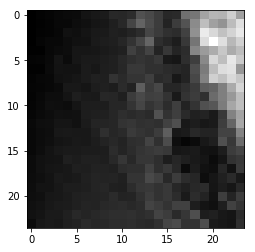

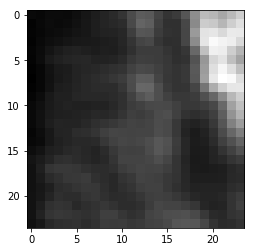

12.632881924510002

 next


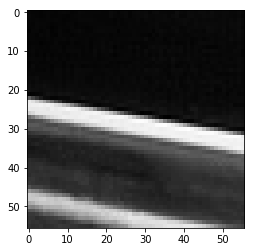

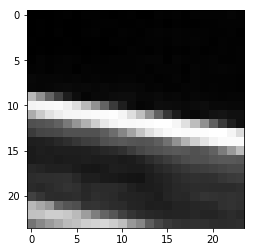

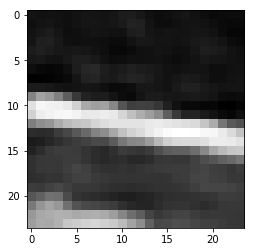

19.561071060597897

 next


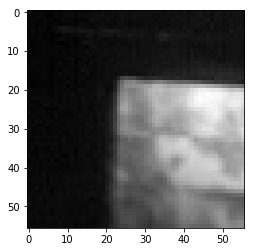

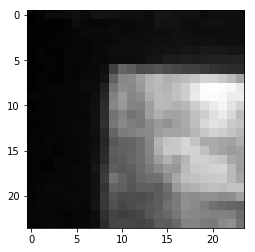

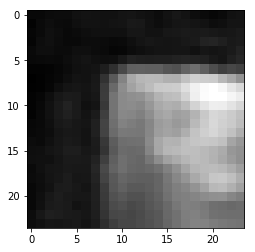

12.202013544738293

 next


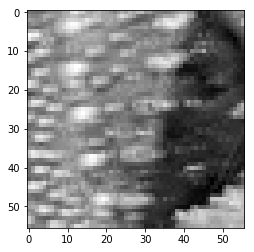

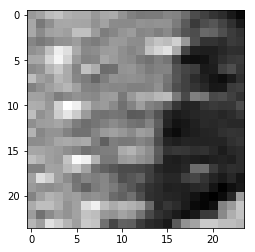

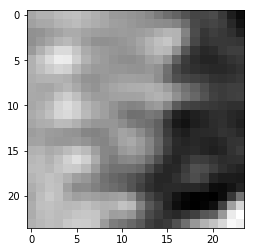

17.988800927996635

 next


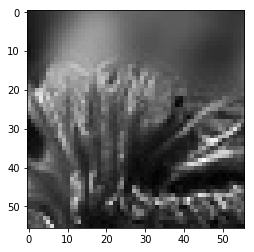

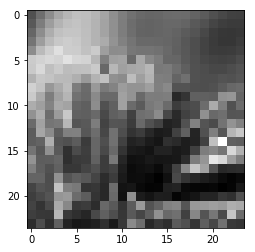

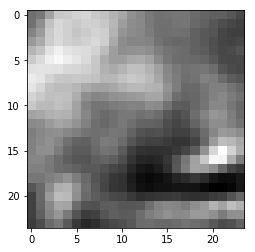

14.42613584920764

 next


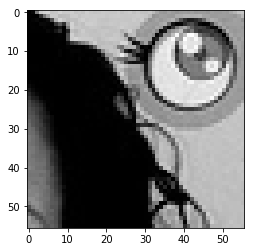

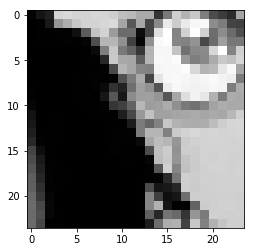

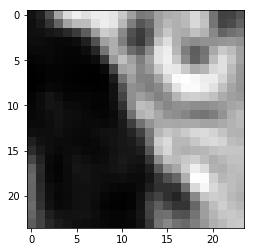

18.951904848217964

 next


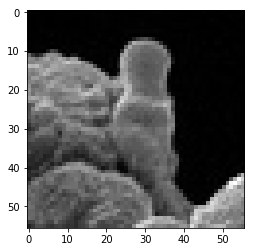

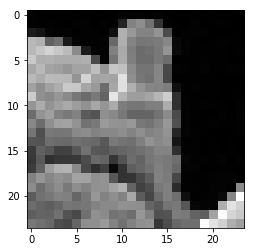

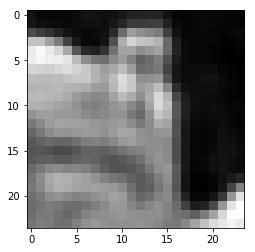

20.29452670365572

 next


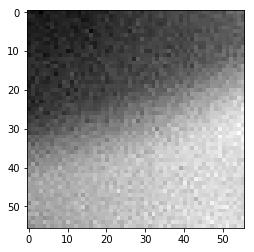

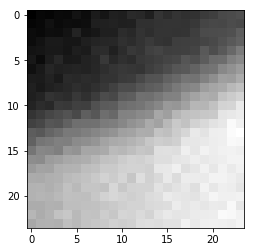

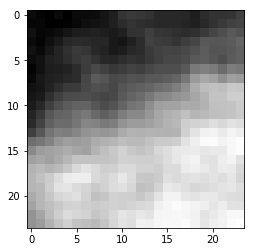

7.801500074565411

 next


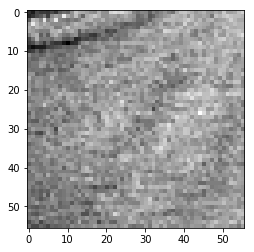

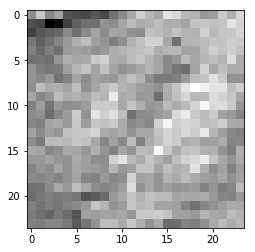

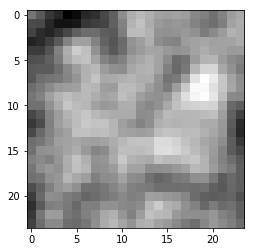

9.779146704822779

 next


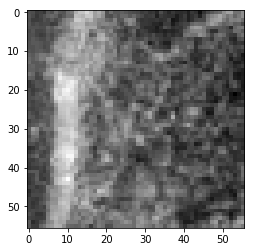

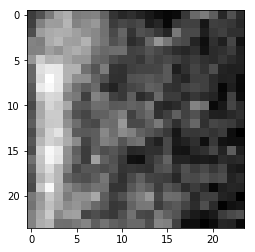

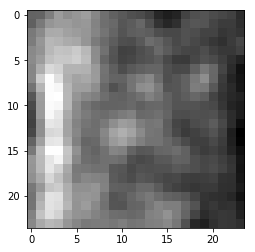

10.297907218337059

 next


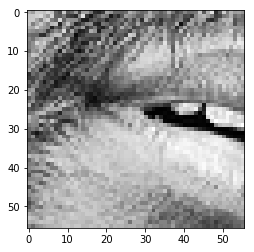

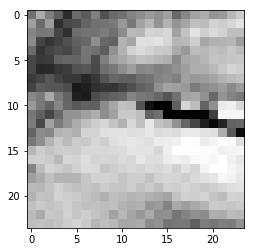

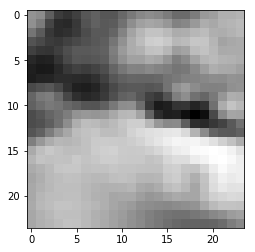

21.296278350055218

 next


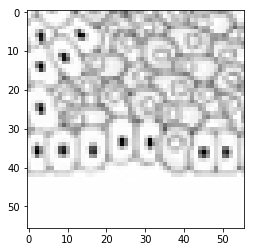

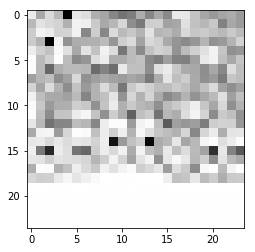

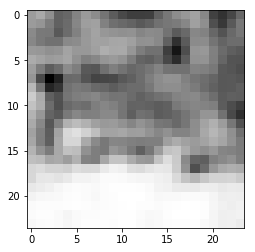

24.76129151880741

 next


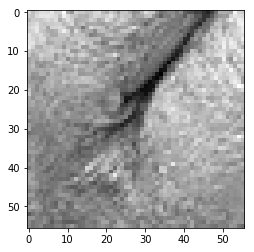

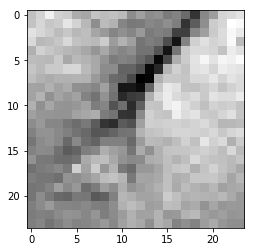

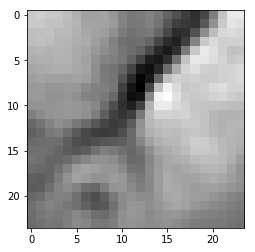

13.269384820014238

 next


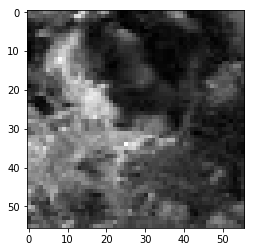

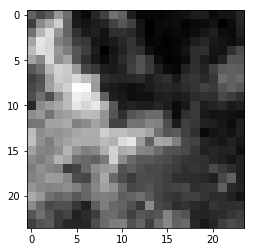

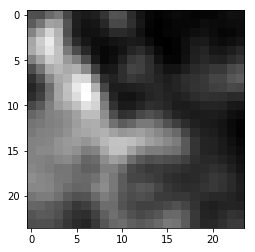

12.869039252400398

 next


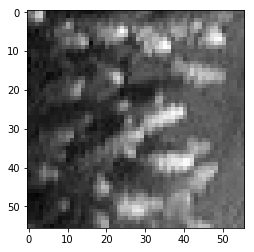

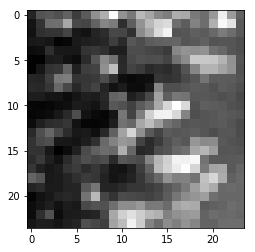

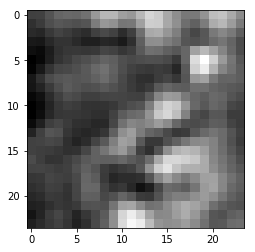

11.096449568867683

 next


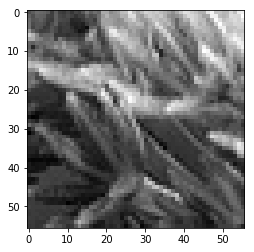

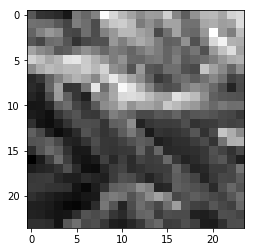

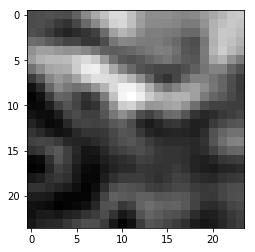

20.3986544162035

 next


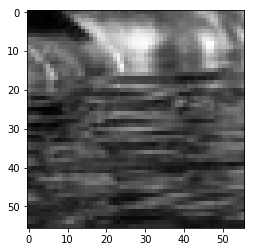

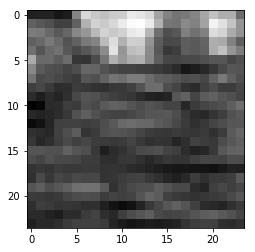

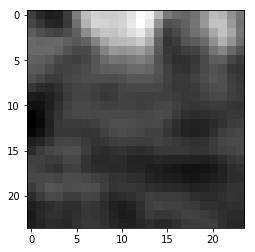

14.037247616797686

 next


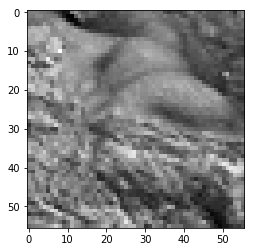

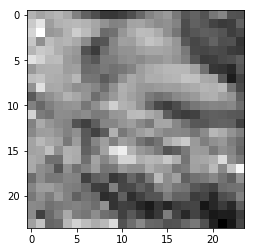

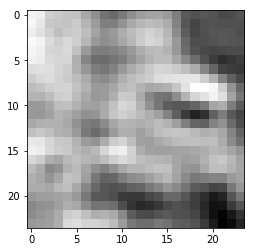

13.920121751725674

 next


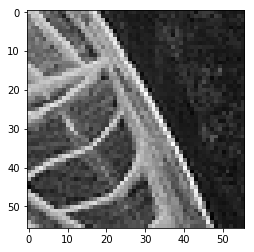

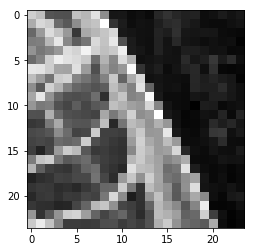

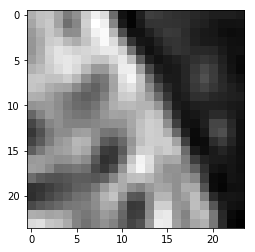

22.79724720865488

 next


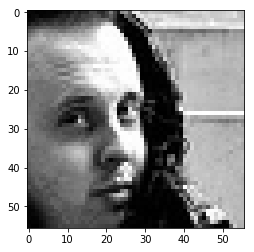

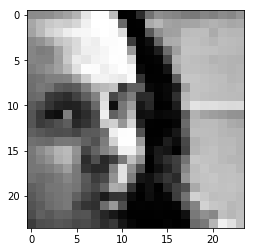

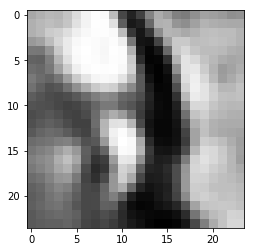

25.229168012738228

 next
0.06474918315187096


In [16]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((24, 24))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [22]:
rmses * 255

14.933308908250183

In [ ]:
input_shape_descr = (input_patch_size, input_patch_size, 1)
input_img_descr = Input(shape=input_shape_descr)

x_descr = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img_descr)
x_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
x_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
average_blurred_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
flattened_descr = Flatten(data_format="channels_last")(average_blurred_descr)
briefed_descr = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened_descr)

descr = Model(input_img, briefed)